# Read libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from copy import copy, deepcopy
from pathlib import Path
from sys import path

path.append( str(Path.cwd().parent) )

In [2]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from matplotlib.gridspec import GridSpec
from numpy import arange, array, exp, isnan, log
from statsmodels.formula.api import ols
from string import punctuation, whitespace


from Project_libraries.my_stats import ( half_frame, place_commas )
from Project_libraries.pubmed import ( get_time_series, plot_time_series,
                                       classify_articles, 
                                       count_articles_by_journal,
                                       get_articles_by_publisher, 
                                     )

In [36]:
# case = 'brca2'
case = 'chest_imaging'
# case = 'green_synthesis'
# case = 'wound_healing'

In [37]:
if case == 'brca2':
    case_folder = Path.cwd() / 'Case_brca2'
    min_size = 150
    
elif case == 'chest_imaging': 
    case_folder = Path.cwd() / 'Case_chest_imaging_pneumonia/'
    min_size = 100
    
elif case == 'green_synthesis':
    case_folder = Path.cwd() / 'Case_green_synthesis_silver_np/'
    min_size = 80
    
elif case == 'wound_healing':
    case_folder = Path.cwd() / 'Case_skin_wound_healing/'
    min_size = 75

print(f"We will be processing the data in folder '{str(case_folder)[77:]}'.\n")

articles_file = case_folder / 'articles_clean.json'
png_file = case_folder / 'time_series.png'

catalogue_file = Path.cwd() / 'Project_libraries' / 'journal_catalogue.json'

We will be processing the data in folder 'Case_chest_imaging_pneumonia'.



# Load journal catalogue

In [38]:
with open(catalogue_file, 'r', encoding = 'utf-8') as file_in:
    catalogue = json.load(file_in)

In [39]:
#Check number of journals without information
#
count = 0
for journal in catalogue:
    if catalogue[journal]['publisher'] is None:
        count += 1
        
        
print(f"There are {len(catalogue)} items in the Journal Catalogue.\n\n"
      f"We lack publisher information for {count} journals.")



There are 3324 items in the Journal Catalogue.

We lack publisher information for 833 journals.


# Import articles

In [40]:
with open(articles_file, 'r', encoding = 'utf-8') as f_json:
    articles = json.load(f_json)
    
print( f"There are {place_commas(len(articles))} articles in the "
       f"'{str(case_folder)[77:]}' collection.\n" )


There are 8,399 articles in the 'Case_chest_imaging_pneumonia' collection.



In [41]:
print( f"We are verifying publisher information for "
       f"{place_commas(len(articles))} articles.\n" )

no_info = []
for i, article in enumerate( articles ):
    journal = article['journal']
    
    journal_info = catalogue[journal]
    
    # We lack info for some journals
#     if journal_info is None:
#         no_info.append(i)
#         for key in ['publisher', 'start_date', 'mesh']:
#             article[key] = None
            
#         continue
    
#     el
    if journal_info['publisher'] is None:
        no_info.append(i)
        for key in ['publisher', 'start_date', 'mesh']:
            article[key] = None

        continue
    
    for key in ['publisher', 'start_date', 'mesh']:
        if key not in journal_info.keys():
            article[key] = None
        else:
            article[key] = journal_info[key]
        
    
print(f"Finished processing all articles.\n\n"
      f"We lack publisher information for {place_commas(len(no_info))} articles.")



We are verifying publisher information for 8,399 articles.

Finished processing all articles.

We lack publisher information for 1,819 articles.


## Calculate breakdown by publisher

In [42]:
publishers = []
for article in articles:
    if 'publisher' in article.keys():
        publishers.append( article['publisher'] )
    
counter = Counter(publishers)

counter.most_common(20)

[('Elsevier', 1876),
 (None, 1819),
 ('Springer Nature', 1305),
 ('Wiley', 521),
 ('Wolters Kluwer', 468),
 ('British Medical Association', 282),
 ('MDPI', 264),
 ('Sage', 161),
 ('Hindawi', 160),
 ('Oxford University Press', 146),
 ('PLoS', 135),
 ('Taylor & Francis', 135),
 ('Frontiers', 108),
 ('Thieme Group', 106),
 ('Chinese Medical Association', 102),
 ('Do Gakkai', 91),
 ('IEEE', 89),
 ('Japanese Society of Internal Medicine', 86),
 ('Karger', 67),
 ('Bentham', 57)]

In [43]:
count_articles_by_journal(get_articles_by_publisher(articles, None), 30)

[('Monaldi Arch Chest Dis', 59),
 ('AJR Am J Roentgenol', 57),
 ('Radiol Med', 48),
 ('Eur Respir J', 33),
 ('Jpn J Radiol', 30),
 ('Kyobu Geka', 30),
 ('Diagn Interv Radiol', 29),
 ('Tuberk Toraks', 28),
 ('Radiographics', 25),
 ('J Korean Med Sci', 24),
 ('Pan Afr Med J', 23),
 ('Korean J Radiol', 19),
 ('Am J Respir Crit Care Med', 19),
 ('Pediatrics', 19),
 ('J Assoc Physicians India', 19),
 ('Zhonghua Wei Zhong Bing Ji Jiu Yi Xue', 19),
 ('J Coll Physicians Surg Pak', 17),
 ('J Infect Dev Ctries', 16),
 ('J Bras Pneumol', 16),
 ('Int J Med Sci', 15),
 ('Kansenshogaku Zasshi', 15),
 ('Praxis (Bern 1994)', 14),
 ('Turk J Med Sci', 14),
 ('Quant Imaging Med Surg', 14),
 ('Med Sci Monit', 13),
 ('Ned Tijdschr Geneeskd', 13),
 ('Kekkaku', 13),
 ('Radiol Cardiothorac Imaging', 13),
 ('Ann Am Thorac Soc', 13),
 ('J Pak Med Assoc', 12)]

# Analyze trends relating to review articles

In [44]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output


# No review articles set
#
no_review_articles = []
for article in articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output


There are 8399 articles in the FULL set; 301 have no abstract; 
17 have been retracted; 101 have had errata published; and 
213 have had comments written about them.


There are 1469 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 22 have had errata published; and 
51 have had comments written about them.


There are 6629 articles in the NO REVIEW set; 0 have no abstract; 
17 have been retracted; 76 have had errata published; and 
142 have had comments written about them.




## Create dataframe with time series 

In [45]:
# year0, year1 = 2000, 2021
year0, year1 = 2000, 2024


df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

df_time_series



,Year,Full Set Papers,FS Retracted,FS Errata,FS Comments,Review Papers,Rev Retracted,Rev Errata,Rev Comments,No Review Papers,NoRev Retracted,NoRev Errata,NoRev Comments
0,2000,103,0,2,0,22,NaN,1,0,75,0,1,0
1,2001,86,0,0,3,20,NaN,0,1,60,0,0,2
2,2002,97,0,0,4,21,NaN,0,2,65,0,0,2
3,2003,99,0,1,4,13,NaN,0,0,78,0,1,1
4,2004,123,0,1,2,23,NaN,0,1,91,0,1,1
5,2005,130,0,0,3,30,NaN,0,1,95,0,0,1
6,2006,118,0,5,2,22,NaN,0,0,90,0,4,2
7,2007,124,0,0,4,27,NaN,0,0,94,0,0,4
8,2008,146,0,1,6,24,NaN,0,2,115,0,1,4
9,2009,134,0,0,0,29,NaN,0,0,99,0,0,0


## Calculate ratios

In [46]:
key = 'Review Papers'
column = f"{key}_ratio"
df_time_series[column] = df_time_series[key] / df_time_series['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']


## Plot data

                            OLS Regression Results                            
Dep. Variable:              ln_Papers   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     52.00
Date:                Fri, 22 Mar 2024   Prob (F-statistic):           3.16e-07
Time:                        17:50:02   Log-Likelihood:                -15.859
No. Observations:                  24   AIC:                             35.72
Df Residuals:                      22   BIC:                             38.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -203.9707     29.028     -7.027      0.0

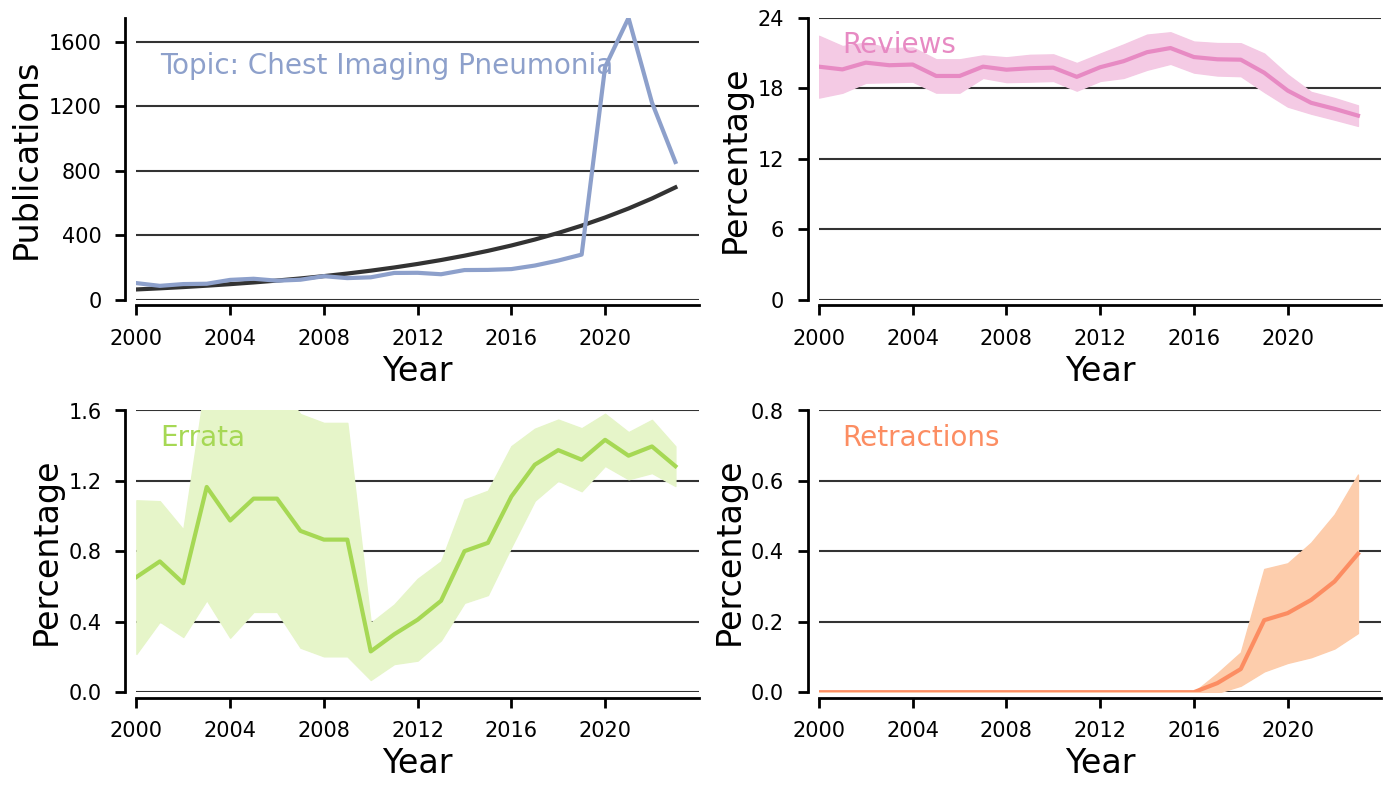

In [47]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

folder = str(case_folder)[77:]

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_time_series, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )

# Add exponential fit
df_time_series['ln_Papers'] = log(df_time_series['Full Set Papers'])
model = ols( formula = 'ln_Papers ~ Year', data = df_time_series)
results = model.fit()
print(results.summary())
ax[-1].plot( df_time_series.Year, 
             exp(results.params.Intercept + results.params.Year * df_time_series.Year),
             lw = 3, color = '0.2', zorder = -3)

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_time_series, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )

ax.append(fig.add_subplot(224))
plot_time_series( ax[-1], df_time_series, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
# plot_time_series( ax[-1], df_time_series, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_time_series, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(png_file)

# Analyze trends by journal


There are 132 articles in the set for PLoS One
There are 132 articles in the FULL set; 0 have no abstract; 
1 have been retracted; 3 have had errata published; and 
0 have had comments written about them.


There are 21 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 1 have had errata published; and 
0 have had comments written about them.


There are 111 articles in the NO REVIEW set; 0 have no abstract; 
1 have been retracted; 2 have had errata published; and 
0 have had comments written about them.



There are 125 articles in the set for Medicine (Baltimore)
There are 125 articles in the FULL set; 0 have no abstract; 
0 have been retracted; 2 have had errata published; and 
0 have had comments written about them.


There are 22 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 103 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retract

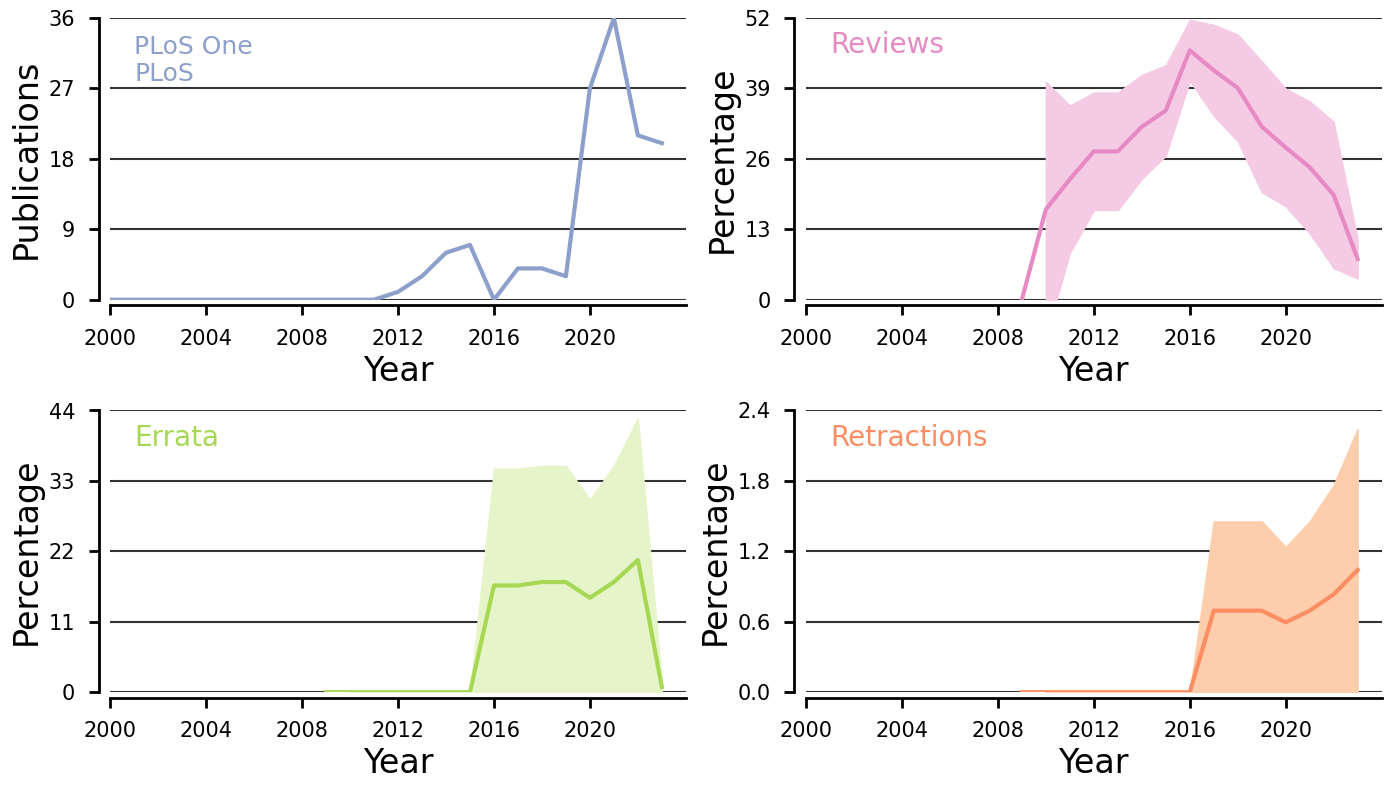

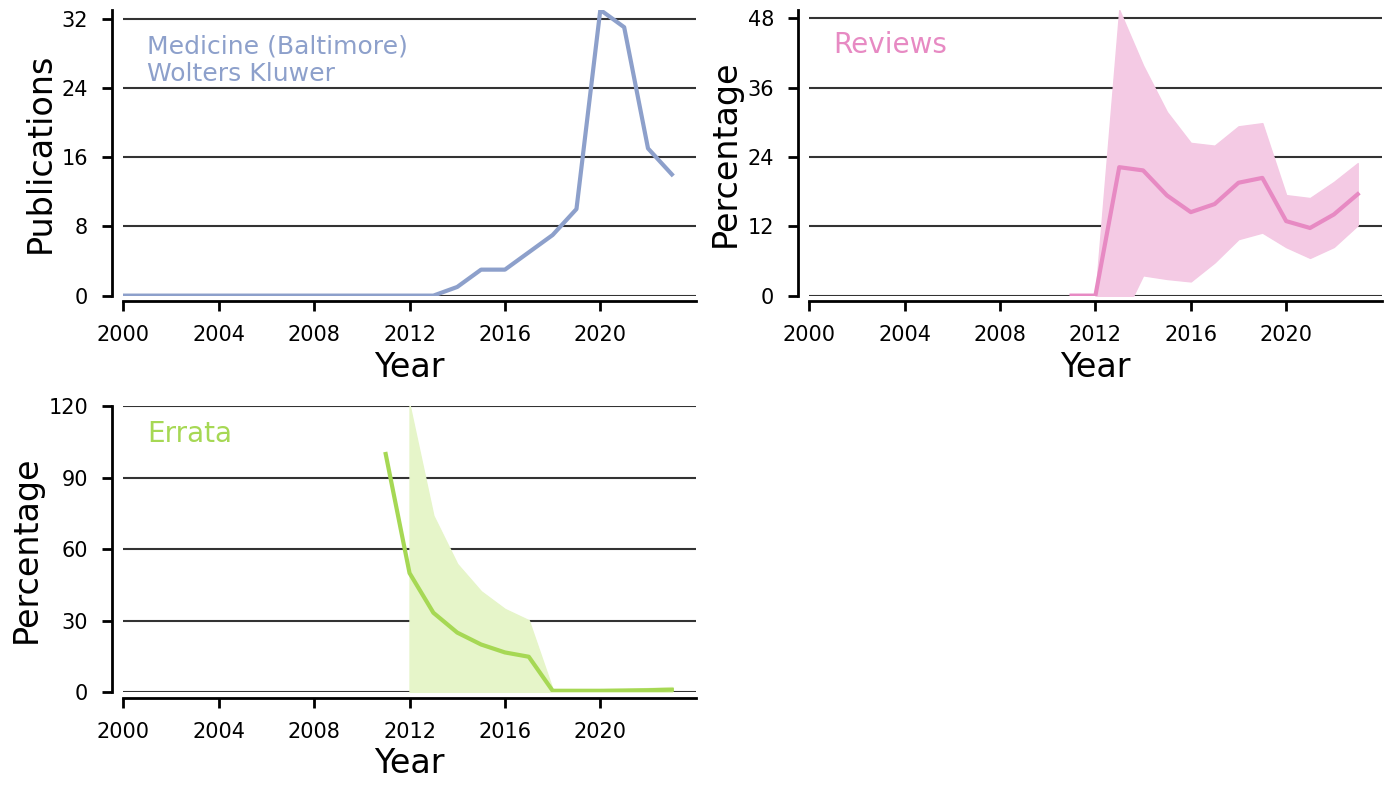

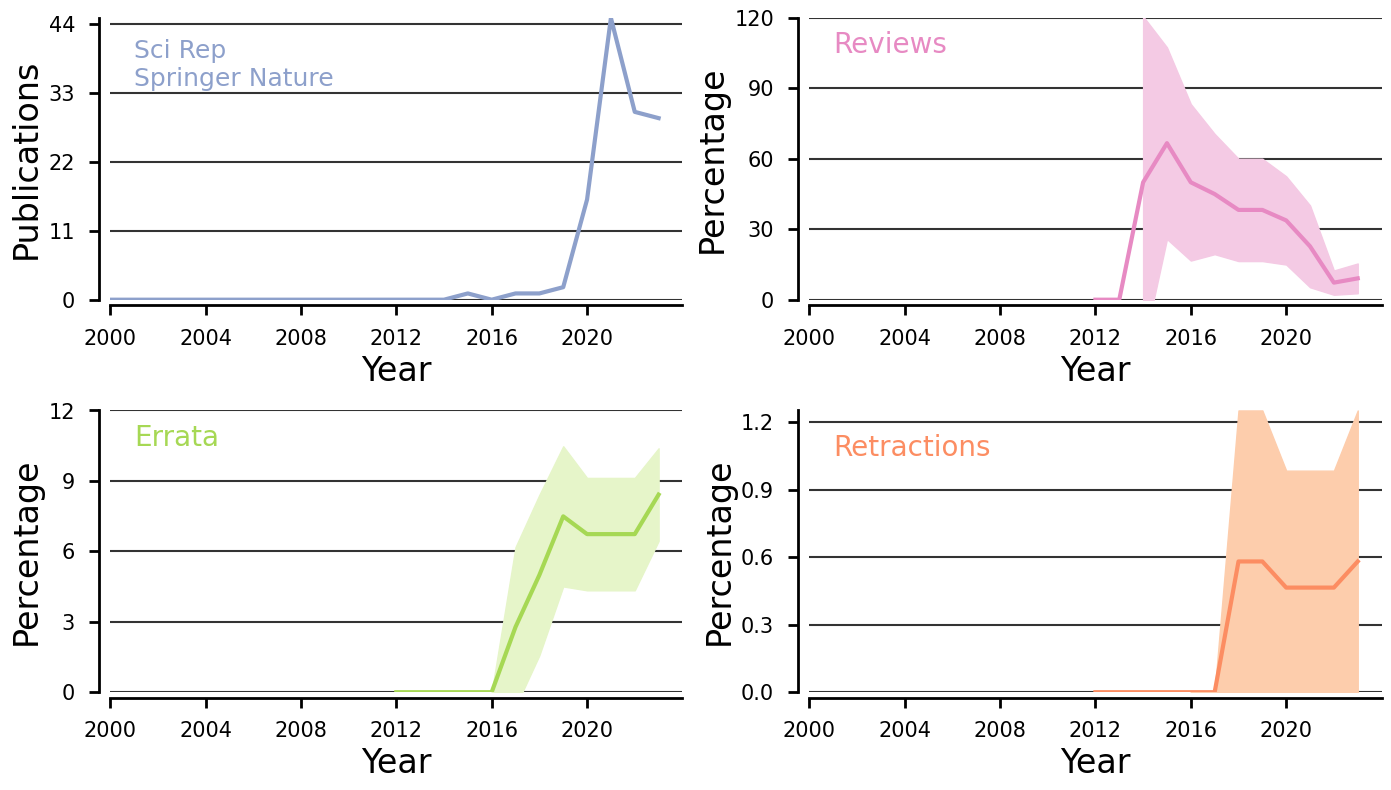

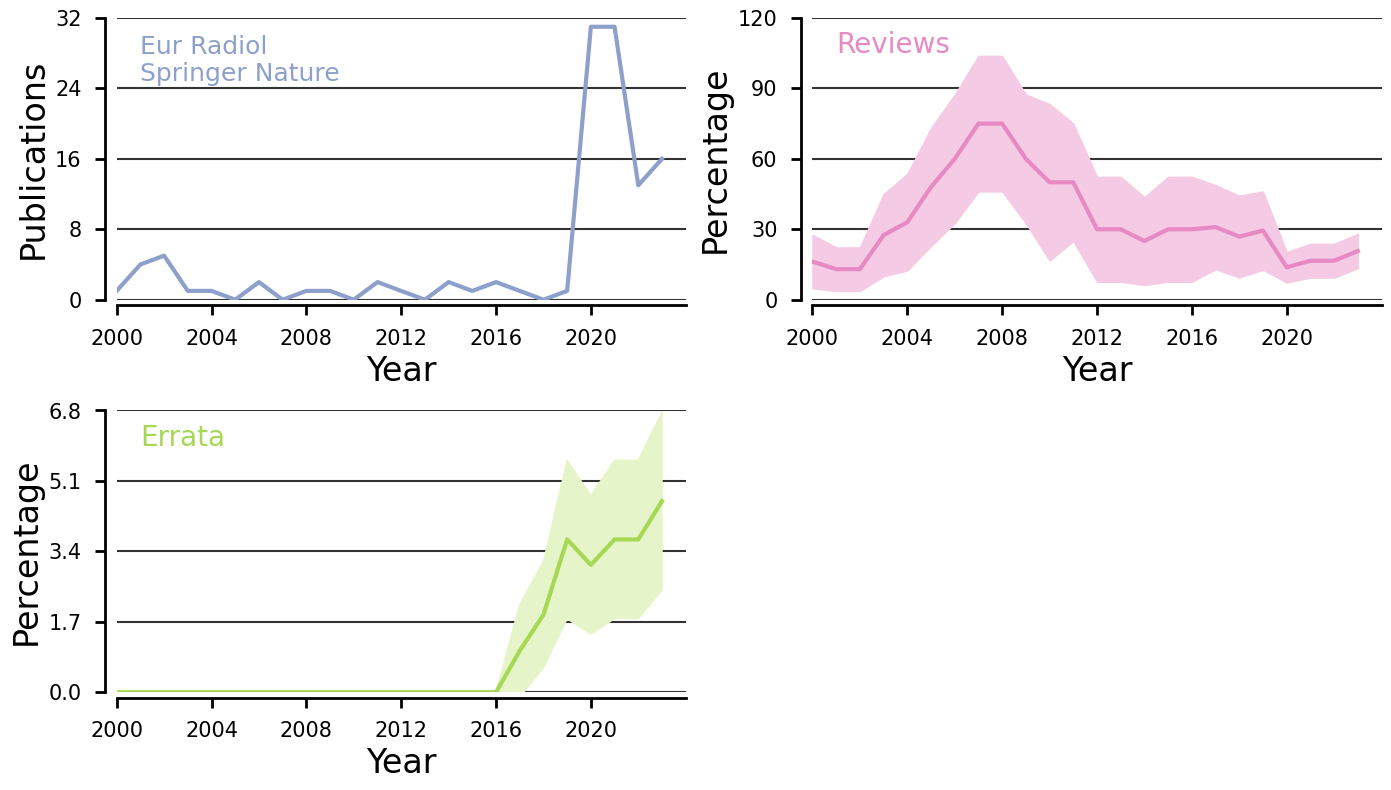

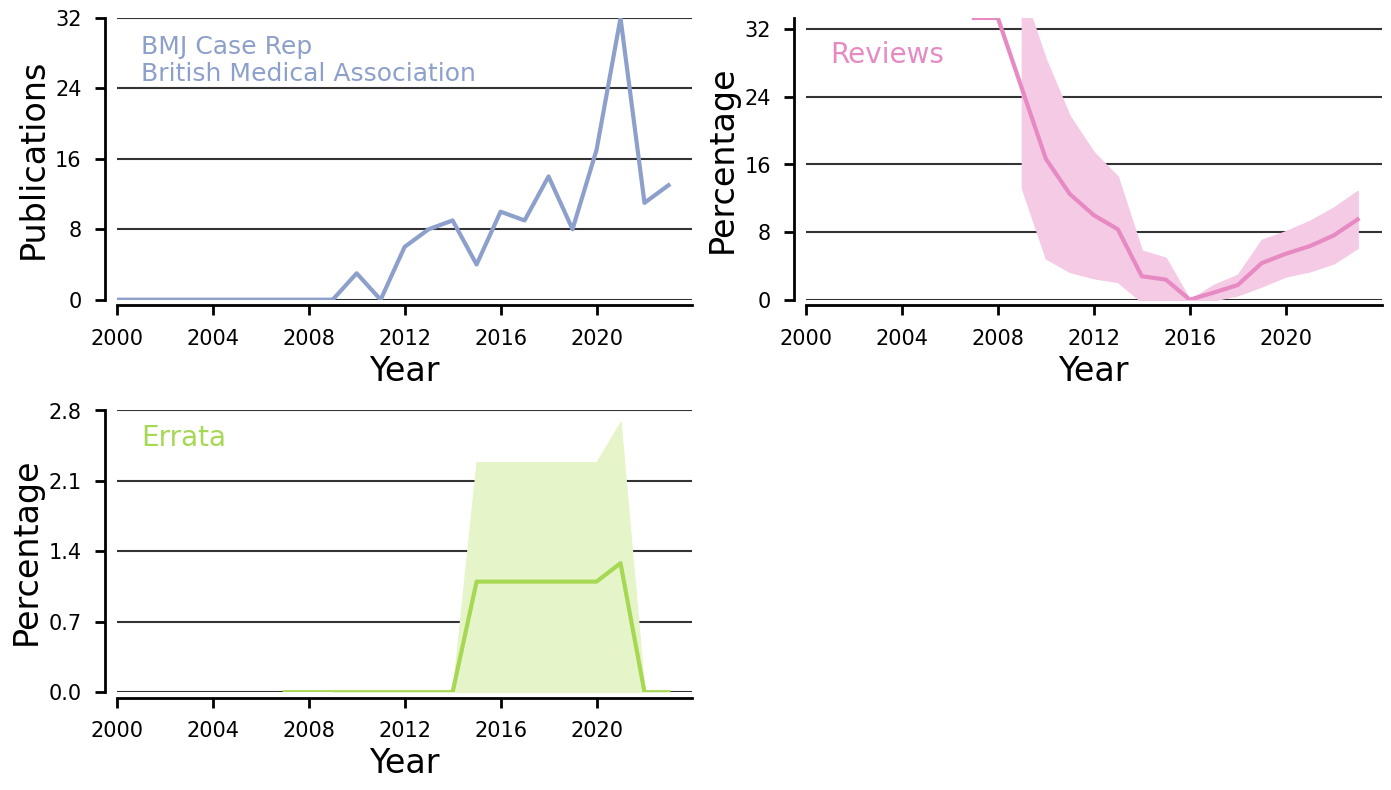

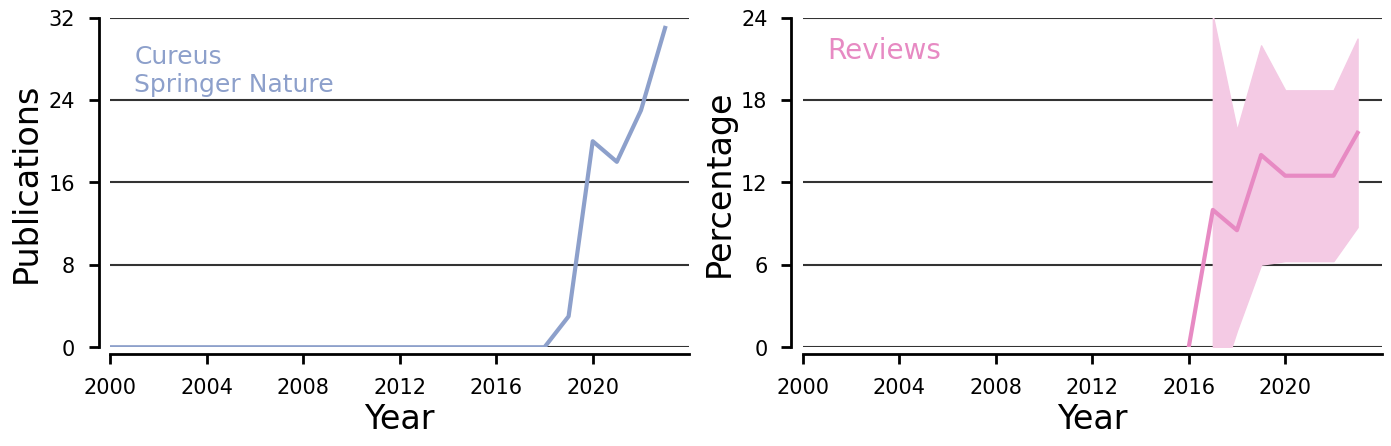

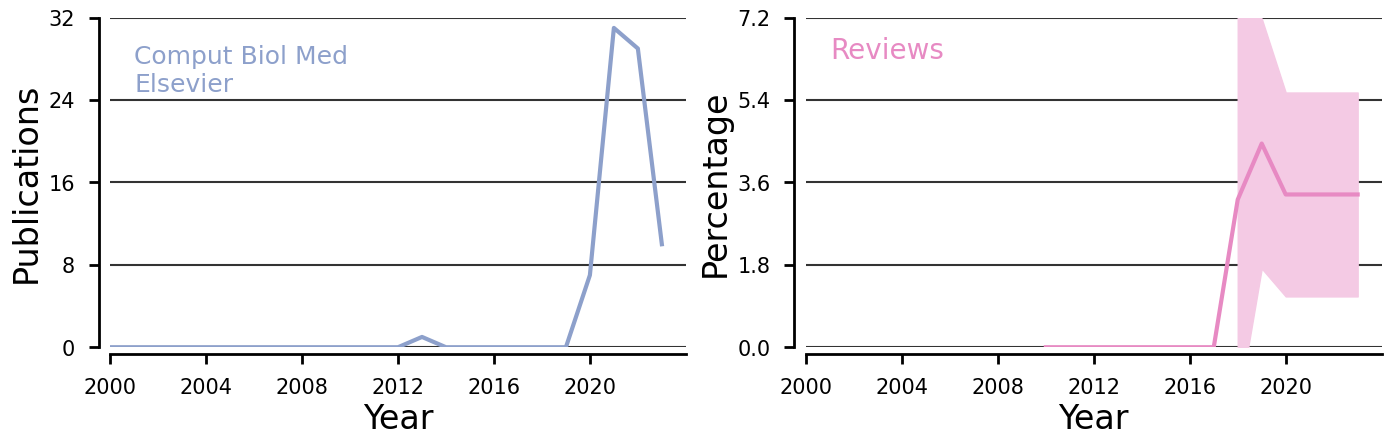

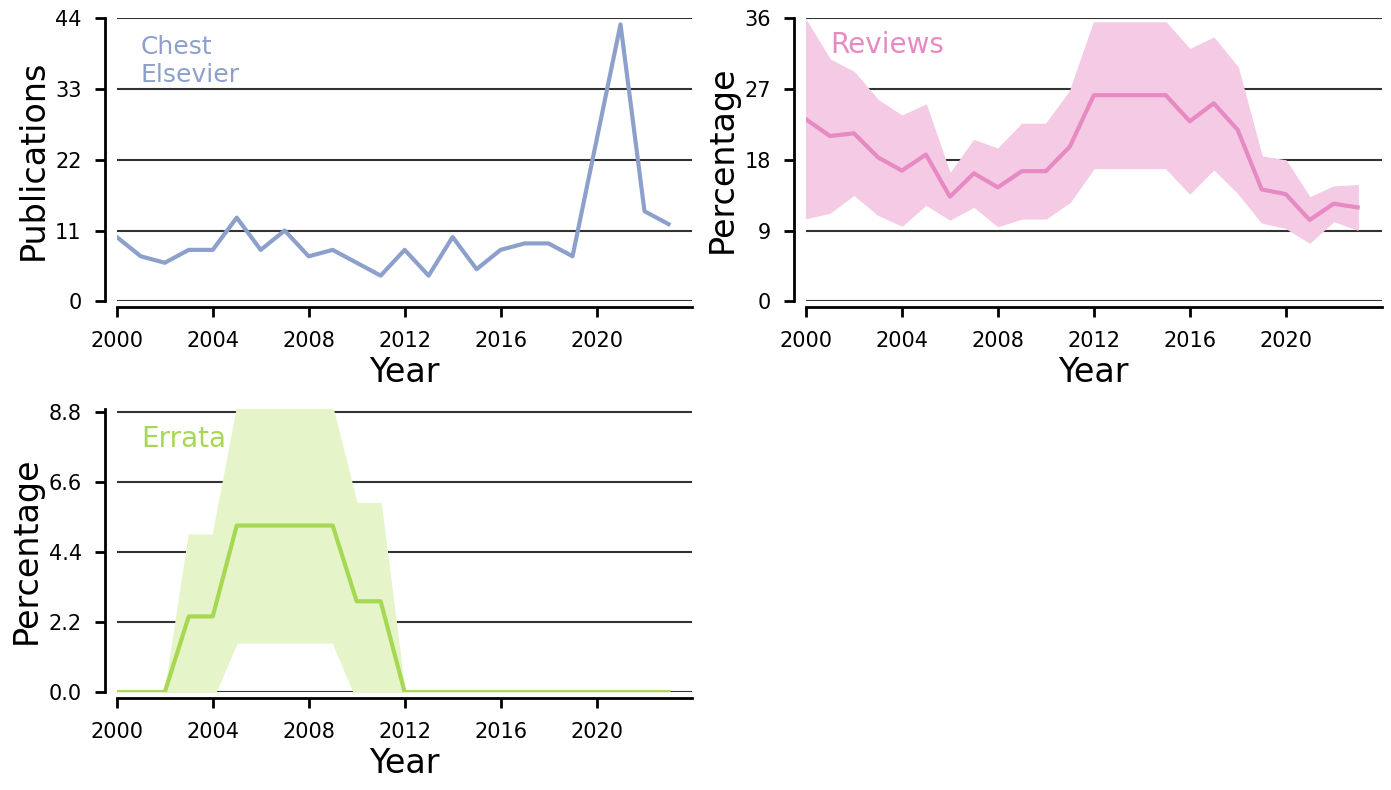

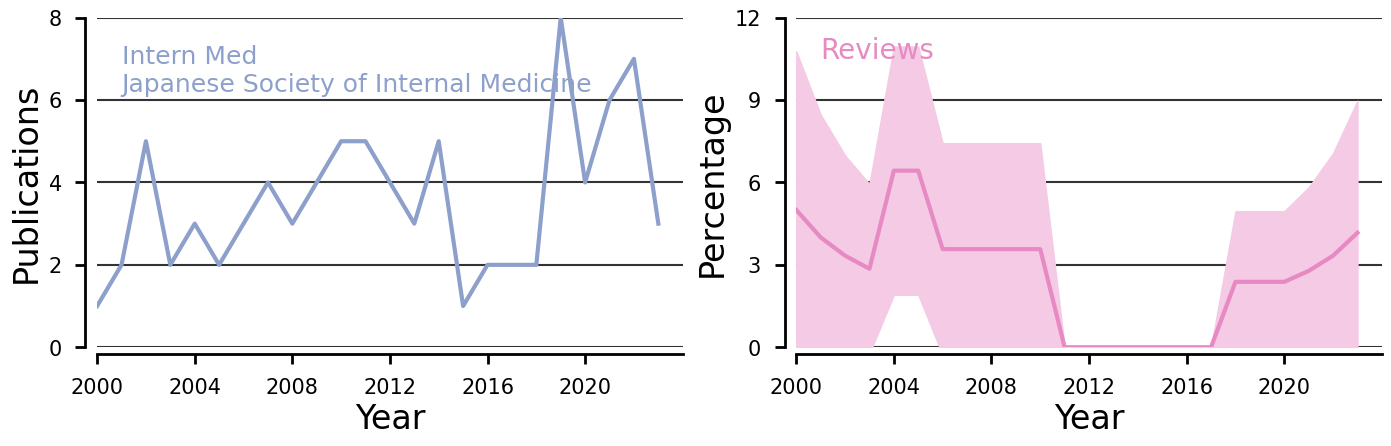

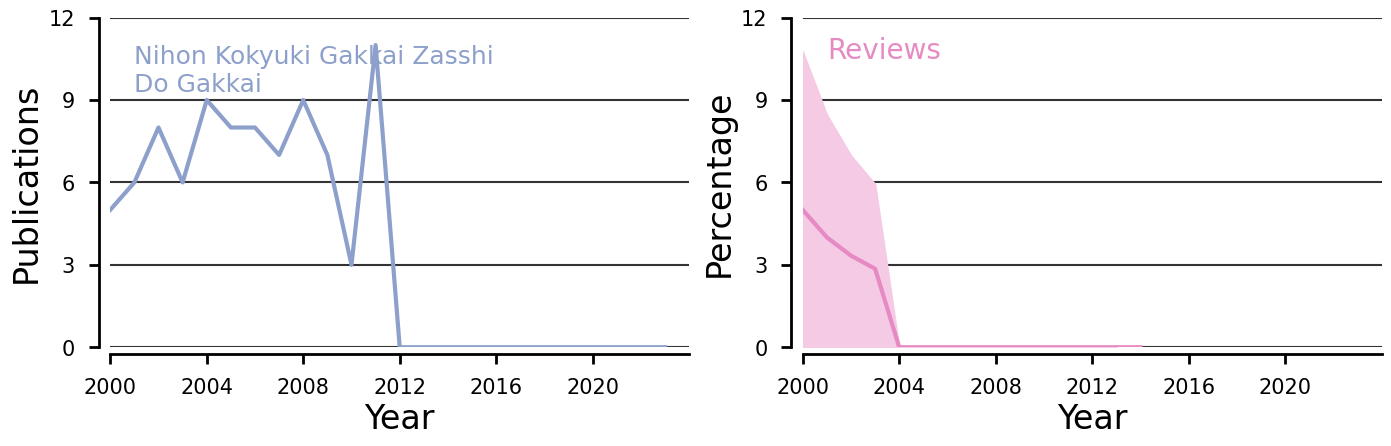

In [48]:
for journal in catalogue: 
    target_articles = []
    for article in articles:
        if article['journal'] == journal:
            target_articles.append( article )    

    if len(target_articles) < min_size * 0.8:
        continue
        
    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{journal}")

    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    # year0, year1 = 2000, 2021
    year0, year1 = 2000, 2024

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    if catalogue[journal] and catalogue[journal]['publisher']:
        my_label = '\n'.join([journal, catalogue[journal]['publisher']])
    else:
        my_label = journal
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      my_label,  
                      colors['Papers'], colors_b['Papers'] )

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Journals' / f"time_series_{journal}.png")

# Analyze trends by publisher


In [49]:
publisher_list = []
for journal in catalogue:
    if catalogue[journal]:
        publisher = catalogue[journal]['publisher'] 
        if publisher not in publisher_list:
            publisher_list.append(publisher )

print(publisher_list)
publisher_list.remove(None)


['Springer Nature', 'IMR Press', 'British Medical Association', None, 'Elsevier', 'Wiley', 'IOS Press', 'Wolters Kluwer', 'American Association for Cancer Research', 'Oxford University Press', 'American Medical Informatics Association', 'Future Science', 'American Medical Association', 'Taylor & Francis', 'Cold Spring Harbor Laboratory Press', 'Mary Ann Liebert', 'PLoS', 'Spandidos', 'American Society of Clinical Oncology', 'De Gruyter', 'Hindawi', 'Canadian Medical Association', 'Cambridge University Press', 'Karger', 'MDPI', 'American College of Physicians', 'Bentham', 'AAAS', 'National Academy of Sciences', 'Zhonghua yi xue hui', 'Lancet', 'Sage', 'American Medical Pub', 'Slovak Academic Press', 'Cell Press', 'Impact Journals', 'CRC Press', 'International Institute of Anticancer Research', 'Biochemical Society', 'Chinese Medical Association', 'Future Science Group', 'American Public Health Association', 'American Chemical Society', 'Meditsina', 'Royal Australian College of General P


There are 1 articles in the set for AAAS

There are 0 articles in the set for AIP Publ

There are 42 articles in the set for AME Publishing

There are 0 articles in the set for Academia Brasileira De Ciencias

There are 3 articles in the set for American Academy of Family Physicians

There are 2 articles in the set for American Association for Cancer Research

There are 0 articles in the set for American Association for Laboratory Animal Science

There are 0 articles in the set for American Association of Immunologists

There are 1 articles in the set for American Chemical Society

There are 3 articles in the set for American College of Physicians

There are 19 articles in the set for American Medical Association

There are 3 articles in the set for American Medical Informatics Association

There are 0 articles in the set for American Medical Pub

There are 8 articles in the set for American Physiological Society

There are 0 articles in the set for American Public Health Association


/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 0 articles in the set for Cold Spring Harbor Laboratory Press

There are 0 articles in the set for Company of Biologists

There are 0 articles in the set for Croatian Academy Of Medical Sciences

There are 5 articles in the set for De Gruyter

There are 91 articles in the set for Do Gakkai

There are 1876 articles in the set for Elsevier
There are 1876 articles in the FULL set; 105 have no abstract; 
1 have been retracted; 21 have had errata published; and 
82 have had comments written about them.


There are 372 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 7 have had errata published; and 
23 have had comments written about them.


There are 1399 articles in the NO REVIEW set; 0 have no abstract; 
1 have been retracted; 11 have had errata published; and 
54 have had comments written about them.



There are 0 articles in the set for FASEB

There are 0 articles in the set for Federation of European Biochemical Societies

There are 108 articles in t

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 11 articles in the set for Future Science

There are 0 articles in the set for Future Science Group

There are 160 articles in the set for Hindawi
There are 160 articles in the FULL set; 0 have no abstract; 
13 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 16 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 144 articles in the NO REVIEW set; 0 have no abstract; 
13 have been retracted; 0 have had errata published; and 
0 have had comments written about them.



There are 89 articles in the set for IEEE

There are 1 articles in the set for IMR Press

There are 12 articles in the set for IOP Publishing

There are 32 articles in the set for IOS Press

There are 7 articles in the set for Impact Journals

There are 0 articles in the set for International Association of Physical Chemists

There are 6 articles in t

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 18 articles in the set for Mary Ann Liebert

There are 8 articles in the set for Meditsina

There are 0 articles in the set for National Academy of Sciences

There are 0 articles in the set for National Research Council of Canada

There are 0 articles in the set for OMICS

There are 146 articles in the set for Oxford University Press
There are 146 articles in the FULL set; 7 have no abstract; 
0 have been retracted; 3 have had errata published; and 
7 have had comments written about them.


There are 26 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
1 have had comments written about them.


There are 113 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 3 have had errata published; and 
6 have had comments written about them.



There are 135 articles in the set for PLoS
There are 135 articles in the FULL set; 0 have no abstract; 
1 have been retracted; 3 have had errata published; and 
0 hav

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 0 articles in the set for Pharmaceutical Society of Japan

There are 1 articles in the set for Pharmaceutical Society of Korea

There are 0 articles in the set for Polski Towarzystwo Farmaceutyczne

There are 1 articles in the set for Royal Australian College of General Practitioners

There are 2 articles in the set for Royal College of Surgeons of England

There are 0 articles in the set for Royal Society

There are 1 articles in the set for Royal Society of Chemistry

There are 8 articles in the set for SPIE

There are 161 articles in the set for Sage
There are 161 articles in the FULL set; 2 have no abstract; 
0 have been retracted; 3 have had errata published; and 
1 have had comments written about them.


There are 32 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
0 have had comments written about them.


There are 127 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 3 have had errata p

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 31 articles in the set for Verduci

There are 521 articles in the set for Wiley
There are 521 articles in the FULL set; 31 have no abstract; 
0 have been retracted; 2 have had errata published; and 
27 have had comments written about them.


There are 99 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
3 have had comments written about them.


There are 391 articles in the NO REVIEW set; 0 have no abstract; 
0 have been retracted; 2 have had errata published; and 
22 have had comments written about them.



There are 468 articles in the set for Wolters Kluwer
There are 468 articles in the FULL set; 12 have no abstract; 
0 have been retracted; 4 have had errata published; and 
12 have had comments written about them.


There are 124 articles in the REVIEW set; 0 have no abstract; 
0 have been retracted; 0 have had errata published; and 
3 have had comments written about them.


There are 332 articles in the NO REVIEW se

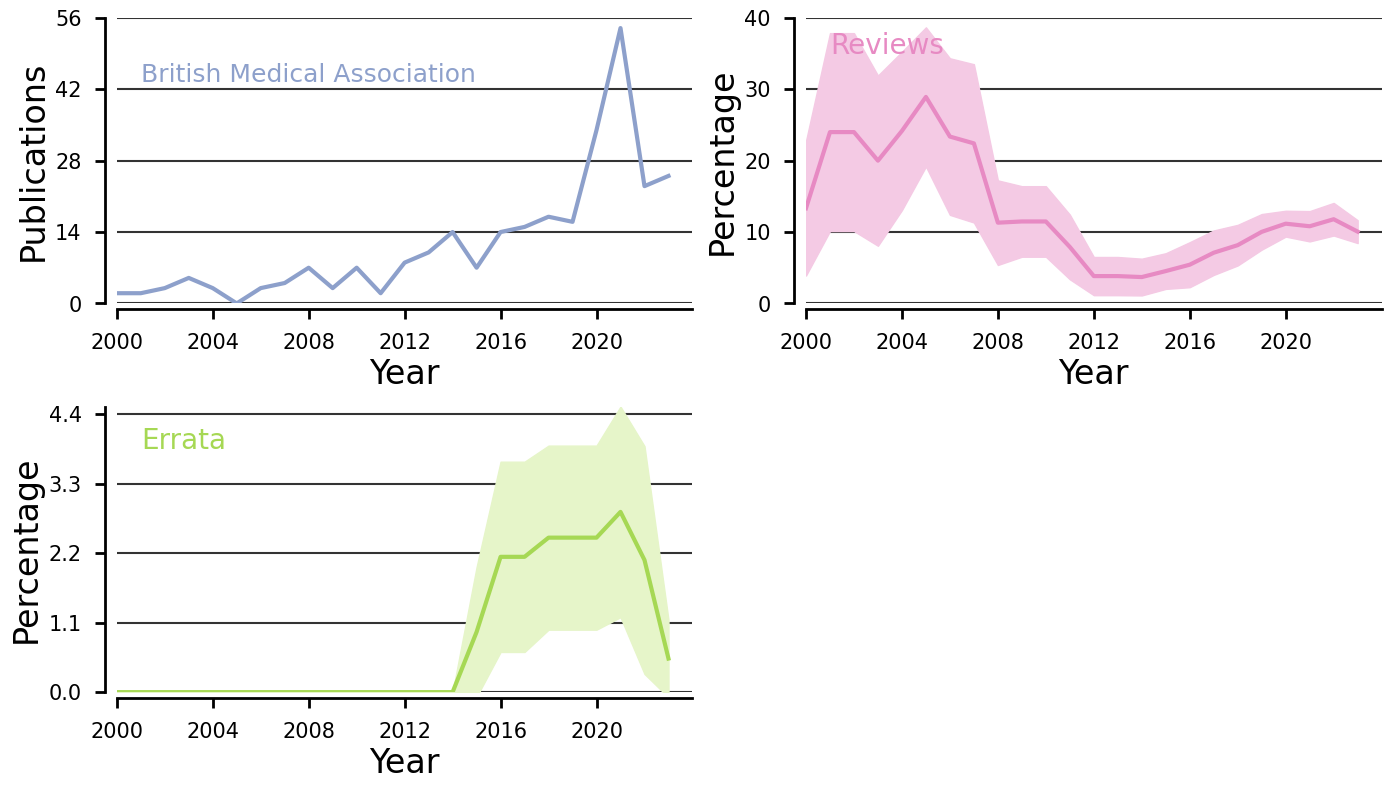

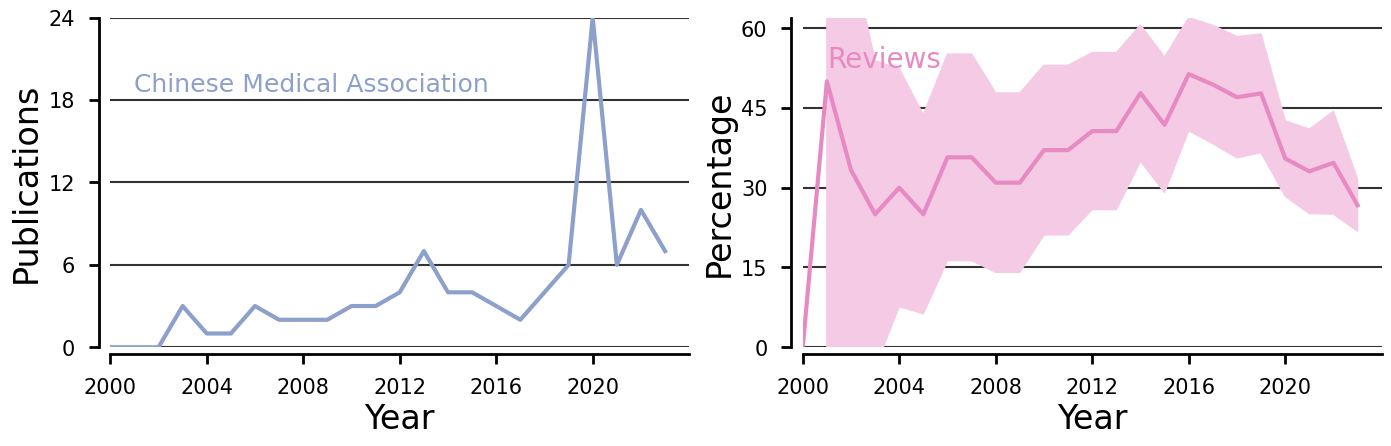

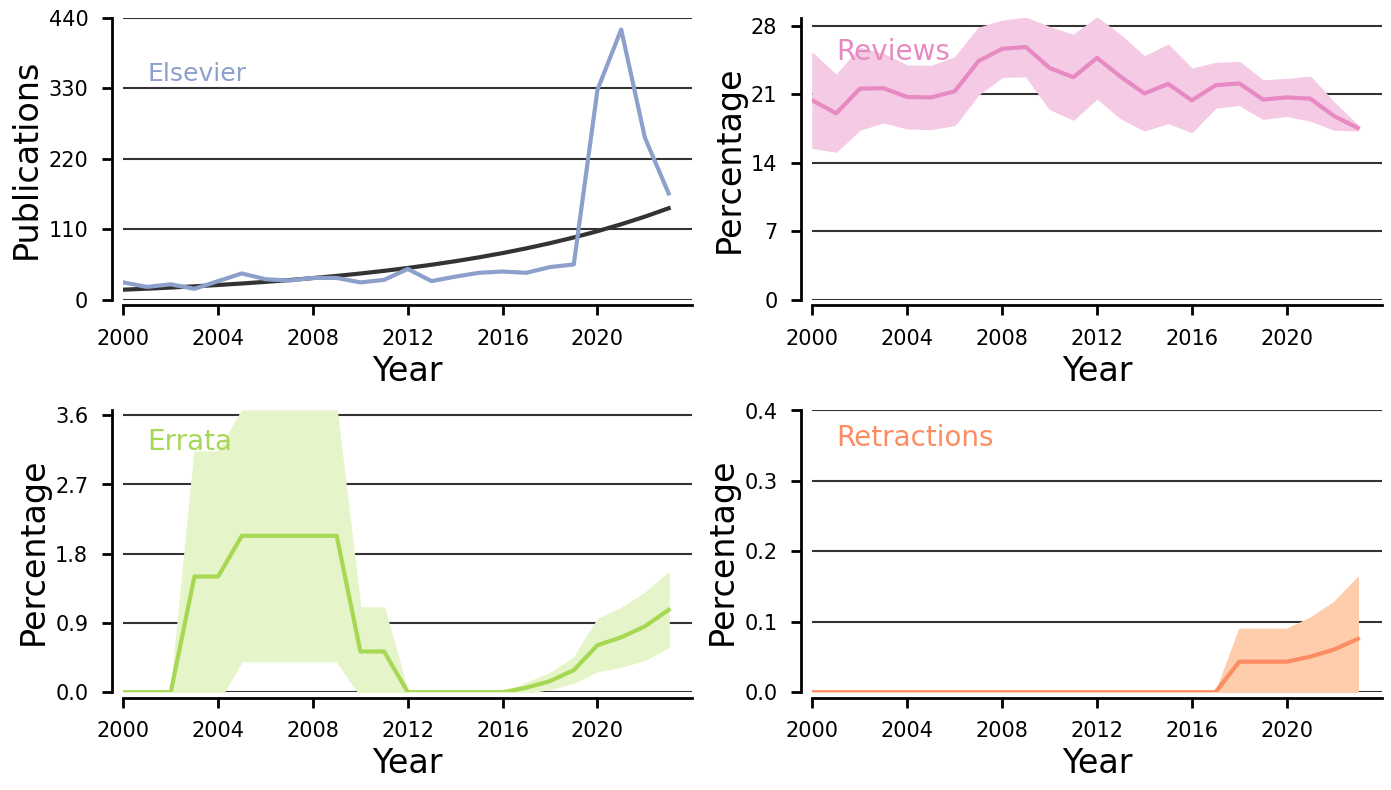

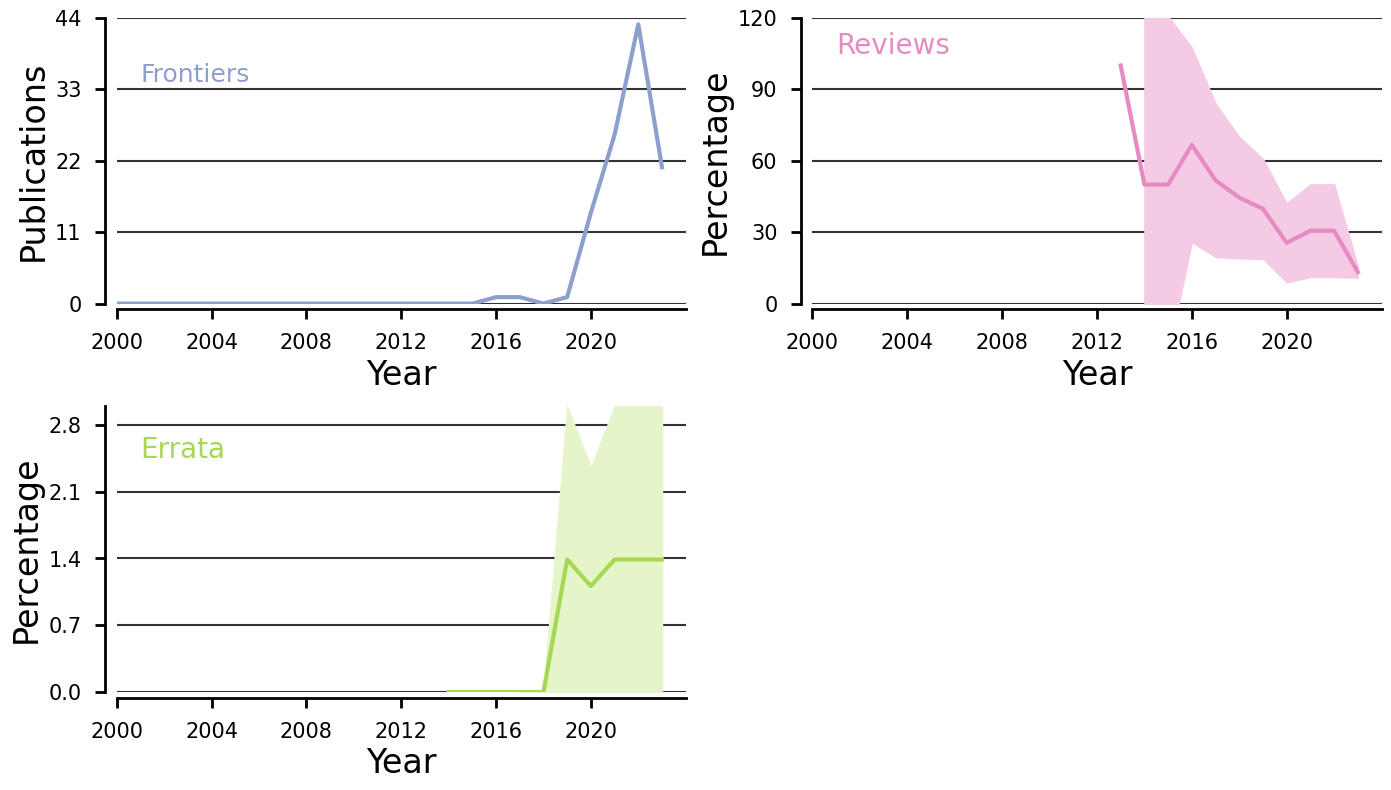

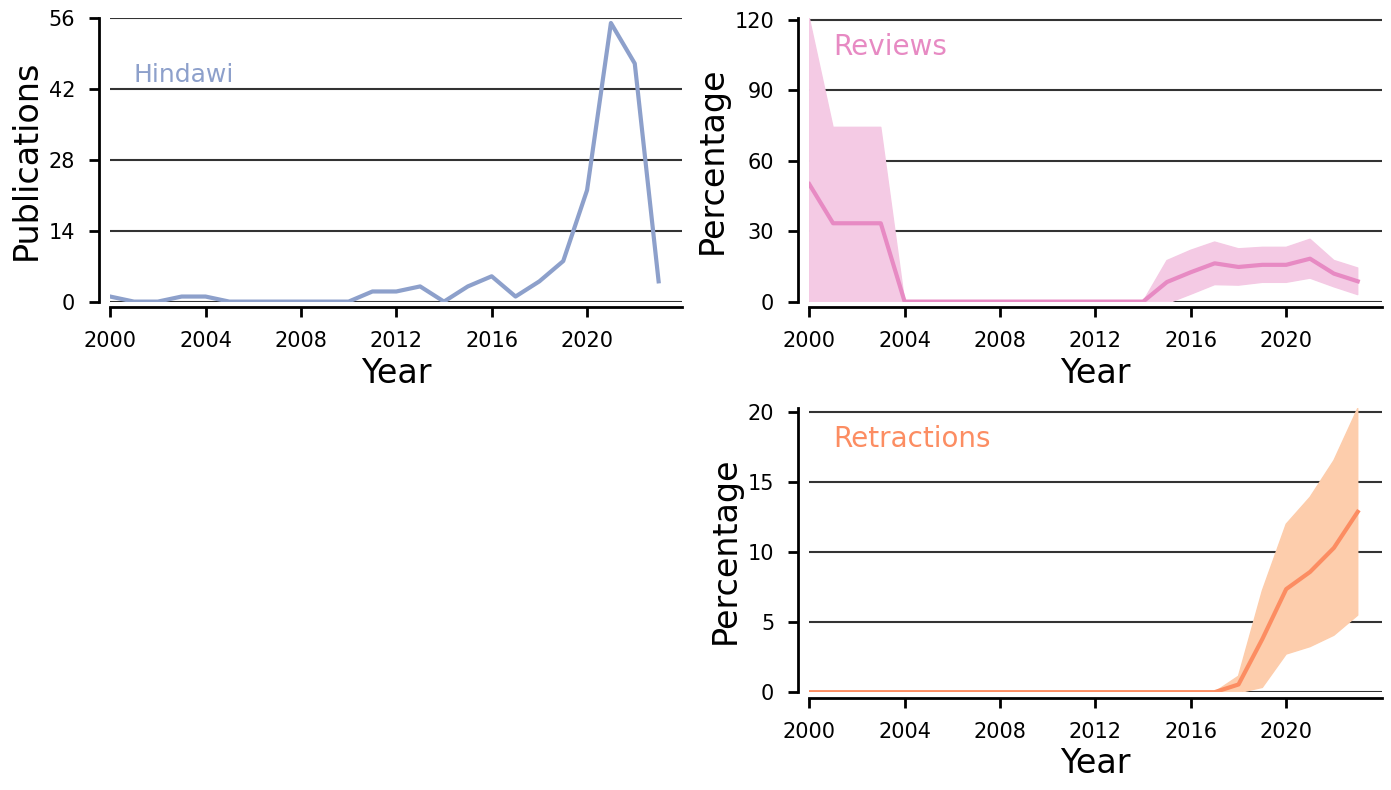

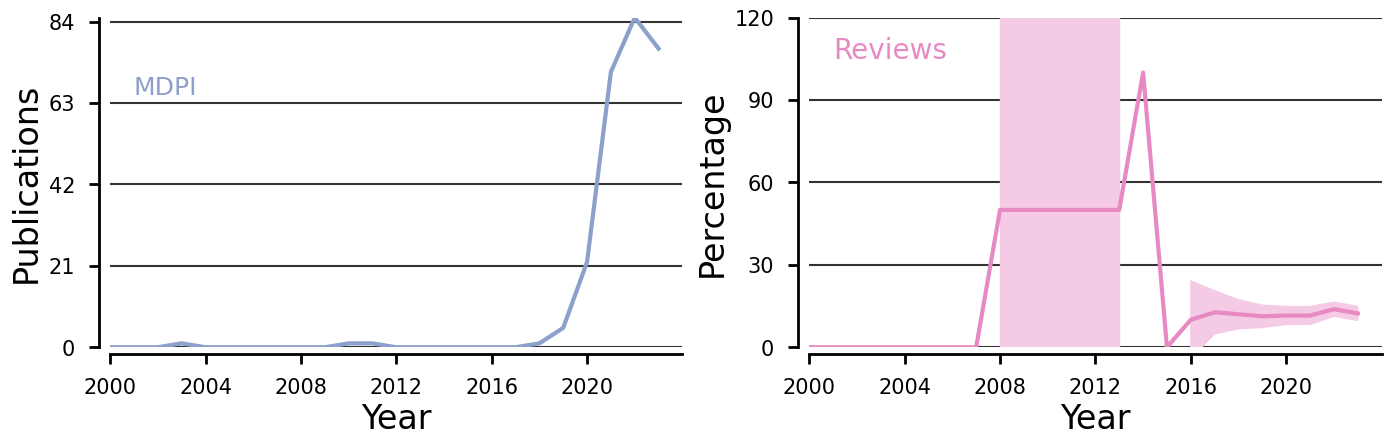

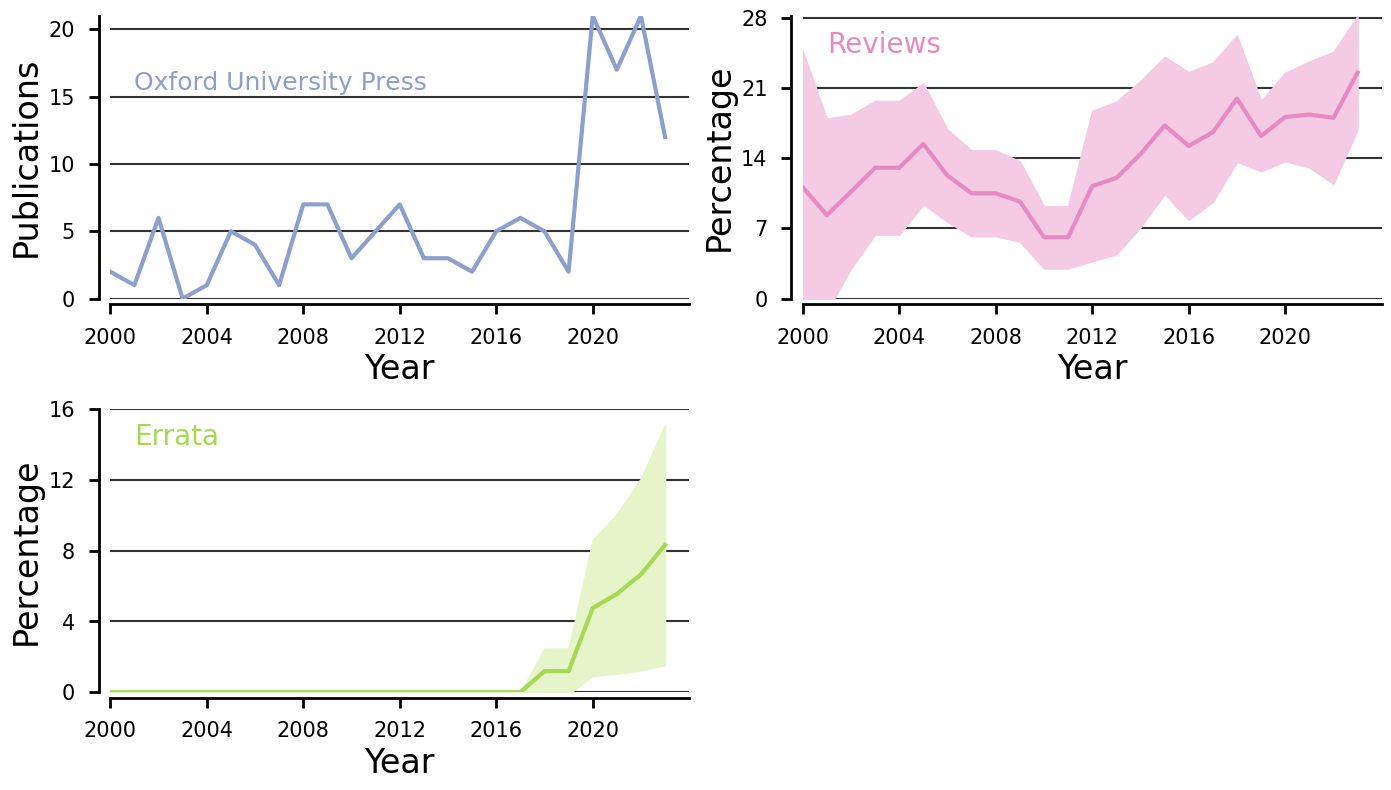

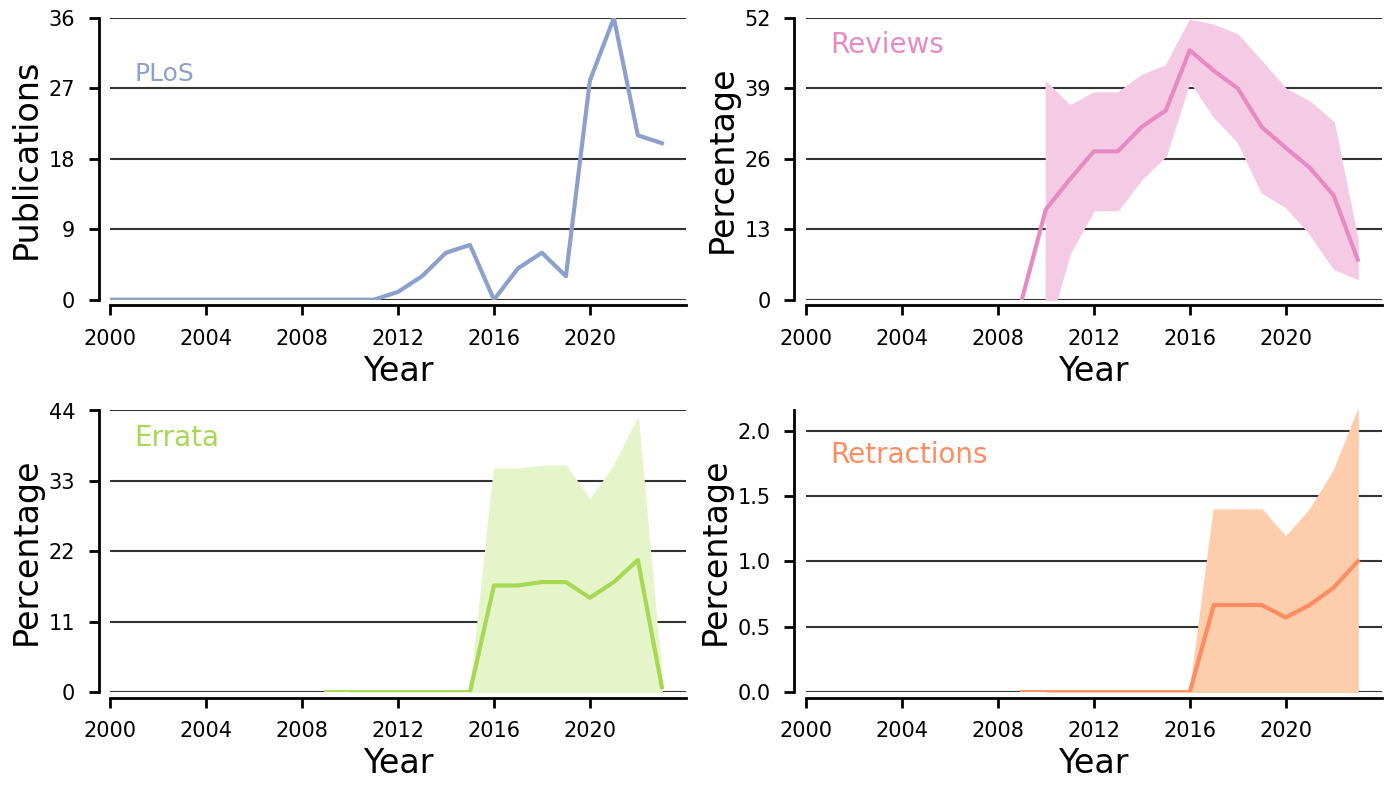

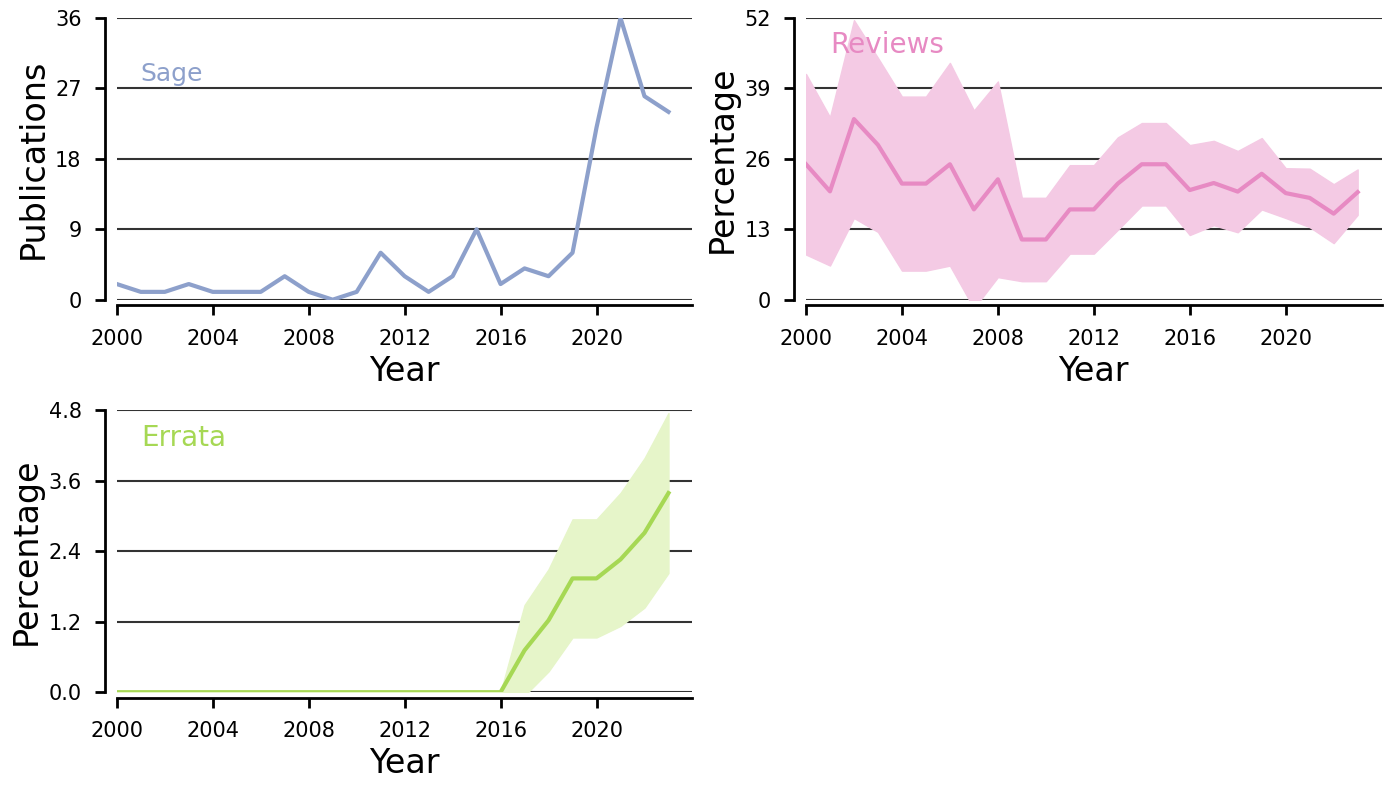

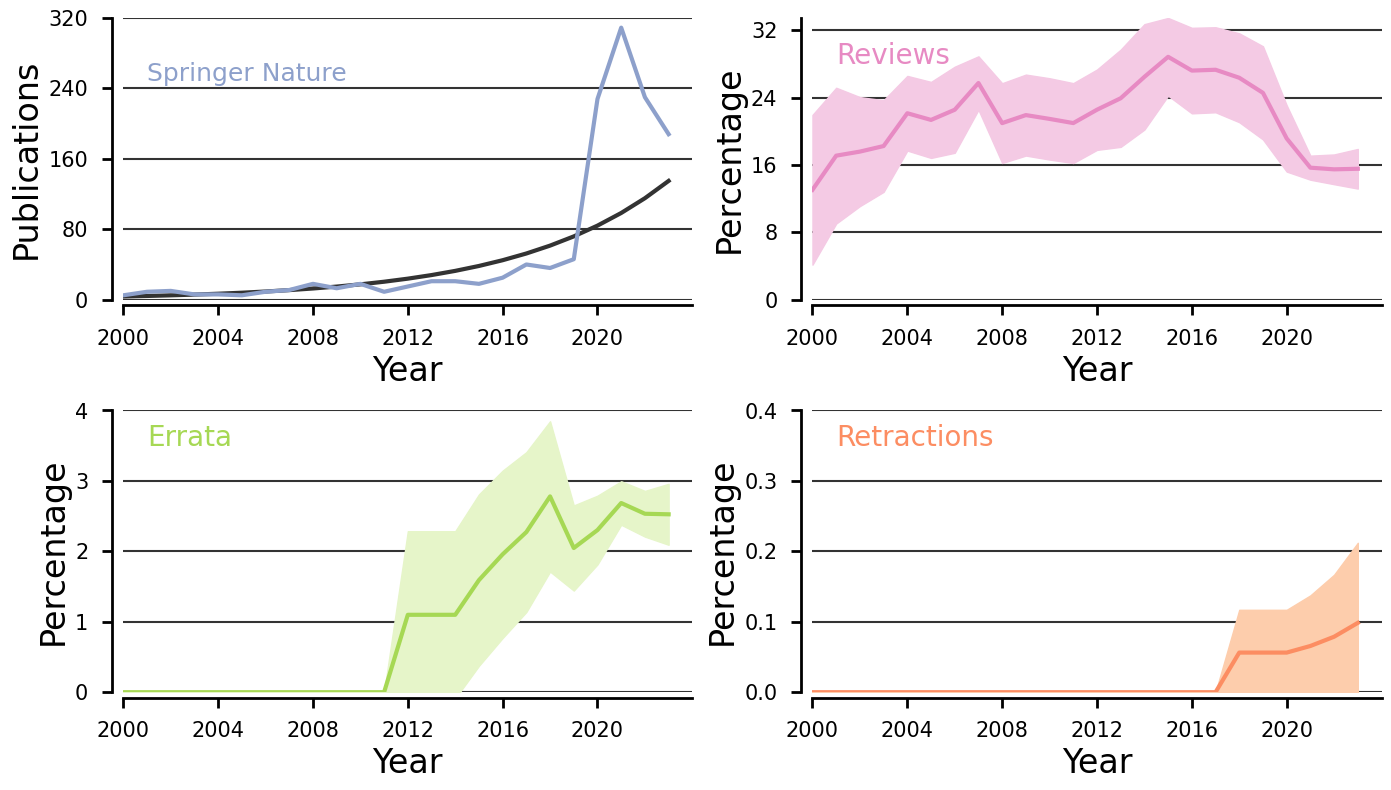

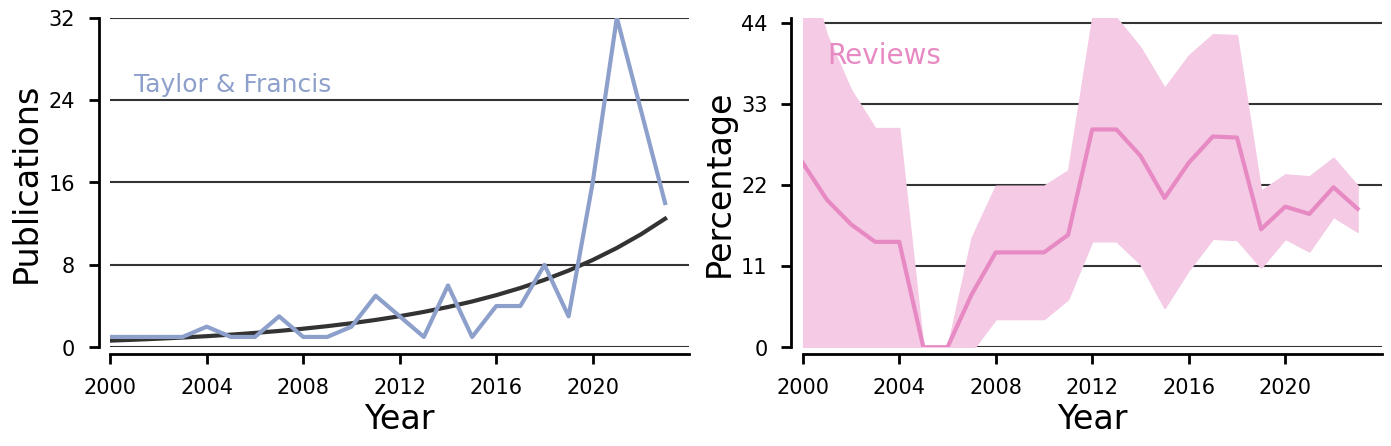

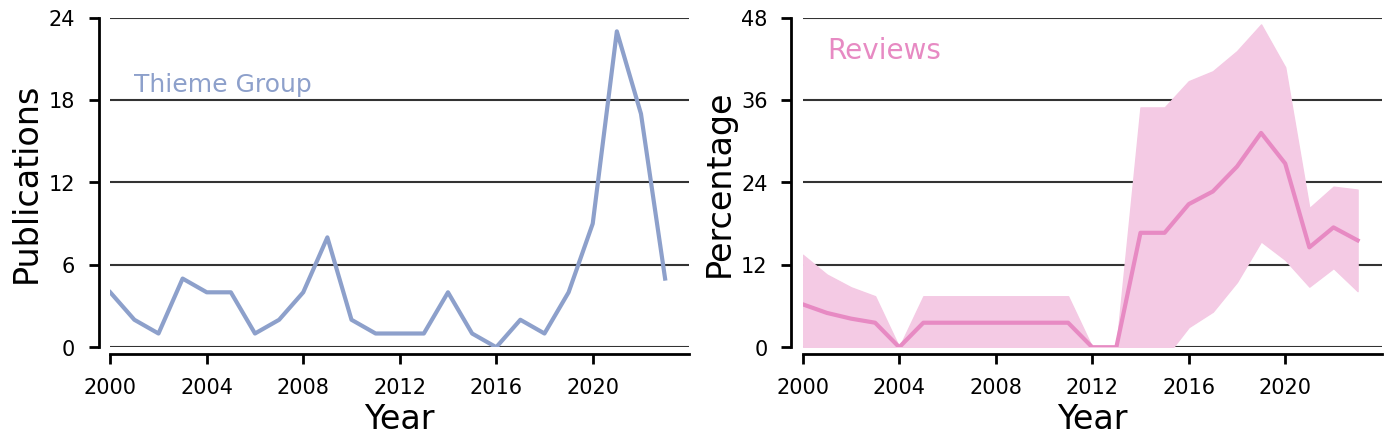

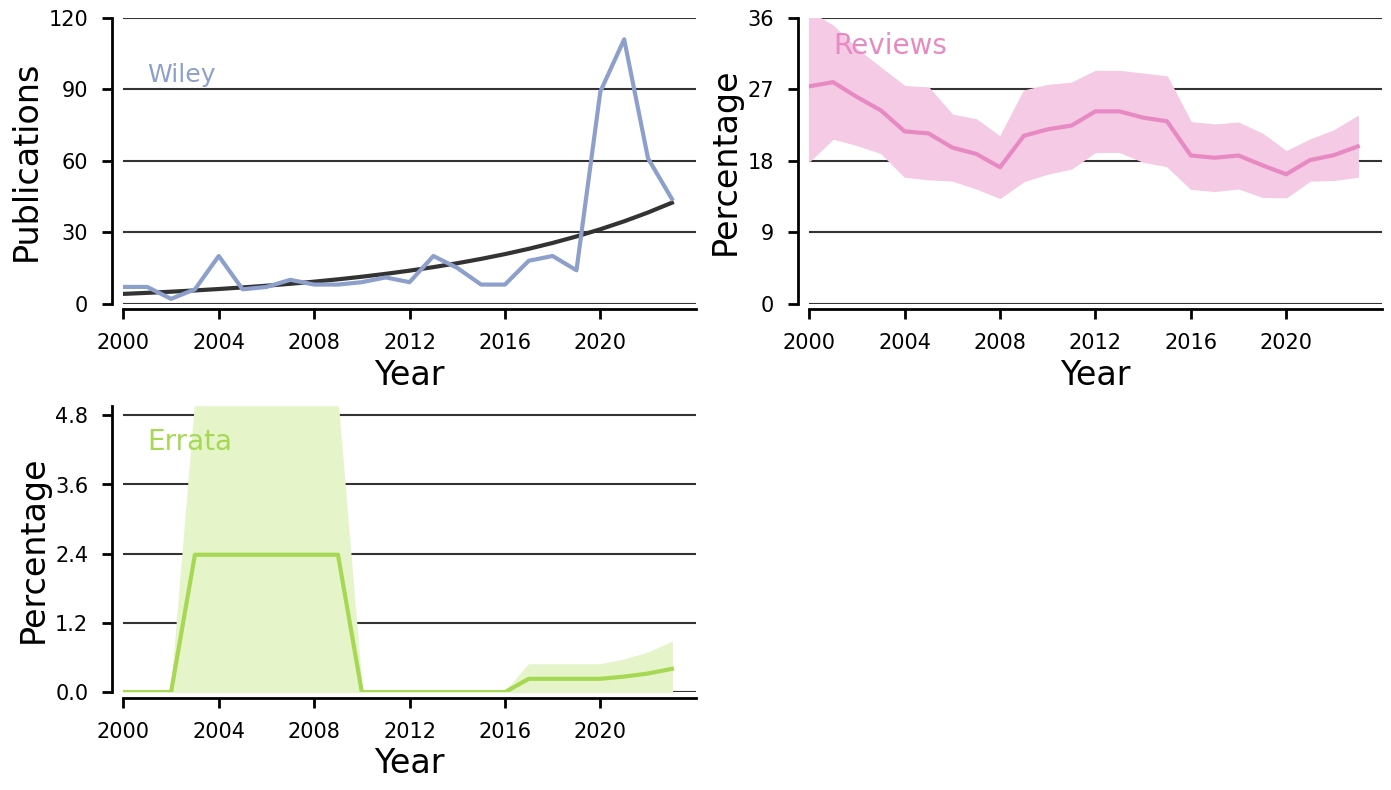

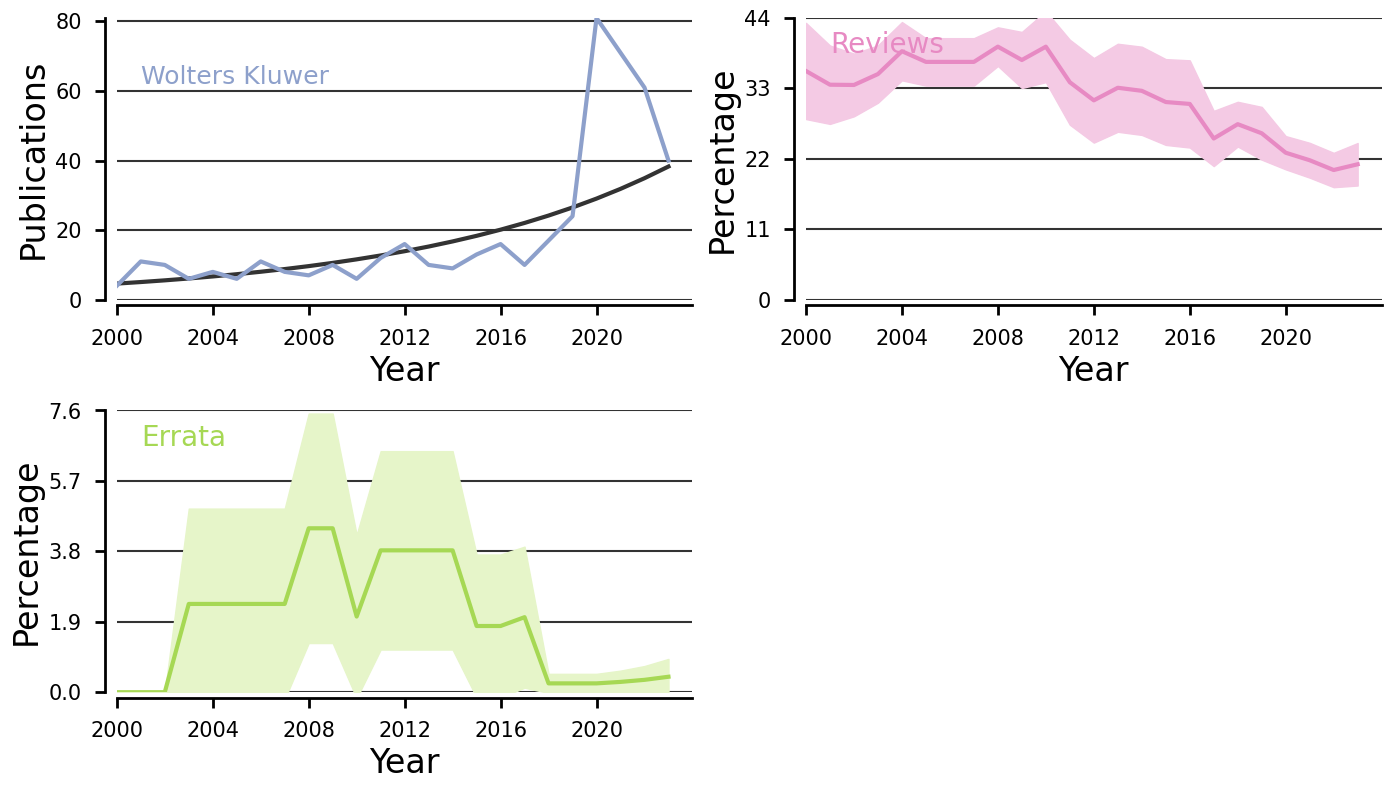

In [50]:
for publisher in sorted( publisher_list ): 
    target_articles = []
    for article in articles:
        if article['publisher']:
            if article['publisher'] == publisher:
                target_articles.append( article )

    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{publisher}")

    if len(target_articles) < min_size:
        continue
        
    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

#     year0, year1 = 2000, 2021
    year0, year1 = 2000, 2024

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      publisher,
                      colors['Papers'], colors_b['Papers'] )
    
    # Add exponential fit
    df_target['ln_Papers'] = log(df_target['Full Set Papers'])
    model = ols( formula = 'ln_Papers ~ Year', data = df_target)
    results = model.fit()
    ax[-1].plot( df_target.Year, 
                 exp(results.params.Intercept + results.params.Year * df_target.Year),
                 lw = 3, color = '0.2', zorder = -3)   

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Publishers' / f"time_series_{publisher}.png")

# Analyze trends relating to publisher type

In [ ]:
target_publishers = [ 'Frontiers', 'Hindawi', 'IOS Press', 
                      'Mary Ann Liebert', 'MDPI', ]

In [ ]:
target_publishers = [ 'American Association for Cancer Research', 
                      'American Medical Association', 
                      'American Chemical Society', 
                      'Cell Press', 'Elsevier', 'FASEB', 'Nature Springer',
                      'Oxford University Press', 
                      'Nature Springer', 
                      'PLoS', 'Royal Society of Chemistry',
                      'Taylor & Francis', ]

# 'Wiley' for skin
# Nature Springer and 'Oxford University Press' dramatically increase
# fraction of reviews over the period for BRAC2


In [ ]:
target_publishers = ['American Society of Clinical Oncology']

In [ ]:
target_code = str(target_publishers).replace(', ', '_').replace("'", '').strip('[]')
print(target_code)

target_articles = []
for article in articles:
    if article['publisher']:
        if article['publisher'] in target_publishers:
            target_articles.append( article )    

print(f"\nThere are {len(target_articles)} articles in the set for "
      f"publishers:\n\t{target_code}")

In [ ]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( target_articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in target_articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output

# No review articles set
#
no_review_articles = []
for article in target_articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

## Create dataframe with time series 

In [ ]:
# year0, year1 = 2006, 2021
year0, year1 = 2000, 2024
# year0, year1 = 2010, 2024

df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                            'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                            'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                            'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                            'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                            'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                            'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                            'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                            'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                            'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                            'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                            'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                            'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                           } )

df_target



## Calculate ratios

In [ ]:
key = 'Review Papers'
column = f"{key}_ratio"
df_target[column] = df_target[key] / df_target['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['No Review Papers']


## Plot data

In [ ]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(224))
# plot_time_series( ax[-1], df_target, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(Path.cwd() / folder / f"time_series_{target_code}.png")